# EZH1

EZH1-related disorders were not listed in OMIM at the time of this writing (2024-09-26). A publication from 2023 describes "Gain and loss of function variants in EZH1 disrupt neurogenesis and cause dominant and recessive neurodevelopmental disorders" ([Gracia-Diaz et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37433783/)). The authors  identified 

> biallelic truncating and heterozygous missense EZH1 variants in 19 individuals with varying degrees of developmental, language and motor delays, mild to severe intellectual disability and dysmorphic facial features.

Furthermore, the authors demonstrated that

>  EZH1 variants cause recessive loss of function (LOF) or dominant gain of function (GOF) effects.

Therefore, we endeavored to test whether there are significant differences in the phenotypic features of these two groups.

We note that we record the disease diagnosis of all individuals as
OMIM:601674 (the identifier for the EZH1 gene), and "EZH1-related neurodevelopmental disorder".

In [2]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


## EZH1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ASPM.

In [3]:
gene_symbol = 'EZH1'
mane_tx_id = 'NM_001991.5'
mane_protein_id = 'NP_001982.2' # histone-lysine N-methyltransferase EZH1 isoform 1 [Homo sapiens]

In [6]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 19 phenopackets
Individuals Processed: 100%|██████████| 19/19 [00:25<00:00,  1.34s/individuals]
Validated under permissive policy
No errors or warnings were found


In [7]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Delayed fine motor development,HP:0010862,19
Delayed speech and language development,HP:0000750,17
Delayed gross motor development,HP:0002194,16
Intellectual disability,HP:0001249,15
Delayed early-childhood social milestone development,HP:0012434,9
Hypotonia,HP:0001252,8
Postural instability,HP:0002172,7
Aggressive behavior,HP:0000718,6
Dysmetria,HP:0001310,5
Autism,HP:0000717,3


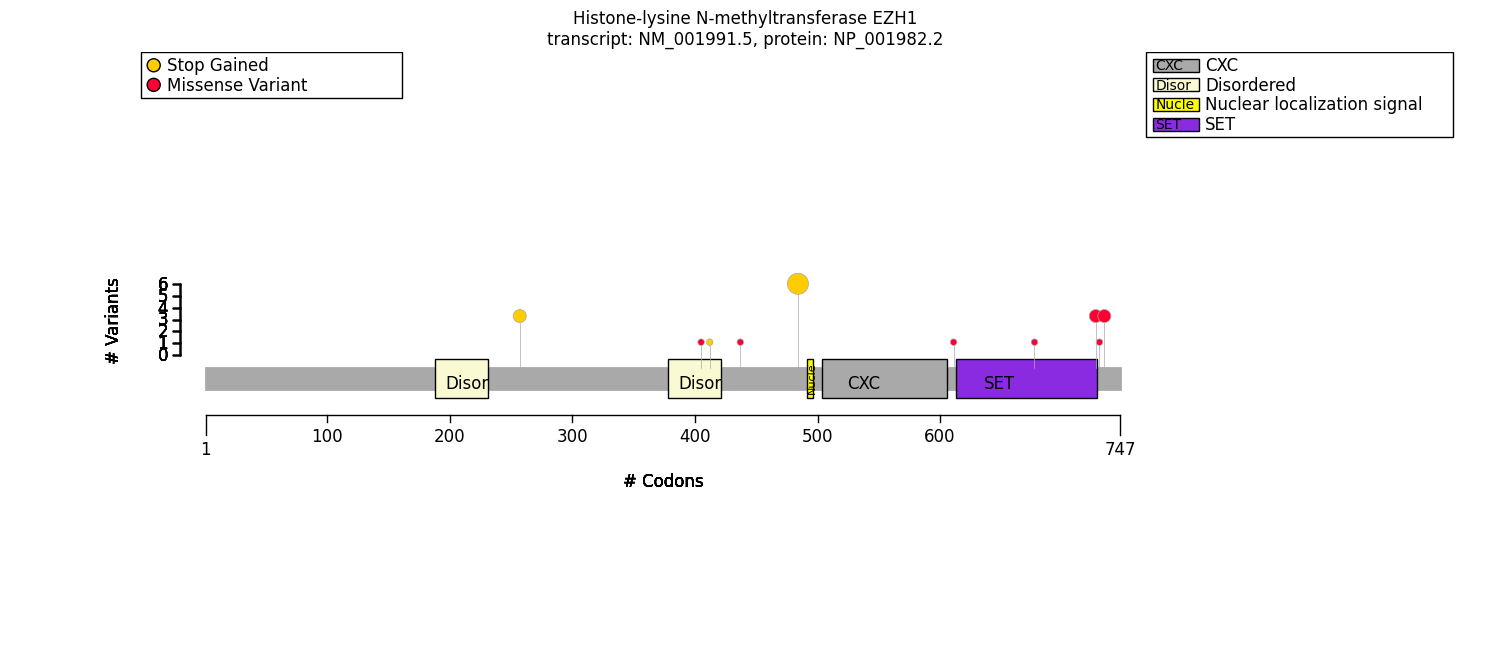

In [8]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [10]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.001,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [11]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant, autosomal_recessive


gt_predicate = autosomal_recessive(partitions={(1,), (2,)})
gt_predicate.display_question()


'What is the genotype group: HET, BIALLELIC_ALT'

In [12]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
report

Code,Reason,Count
HMF02,Skipping term because no genotype has more than one observed HPO count,10
HMF04,Skipping term because all genotypes have same HPO observed proportions,24
HMF06,Skipping term with less than 7 observations (not powered for 2x2),85
HMF08,Skipping general term,42


In [14]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                           HET          \
                                                   Count Percent   
Joint stiffness [HP:0001387]                         2/7     29%   
Aggressive behavior [HP:0000718]                     3/6     50%   
Hypotonia [HP:0001252]                               5/8     62%   
Dysmetria [HP:0001310]                               2/5     40%   
Autism [HP:0000717]                                  2/6     33%   
Delayed early-childhood social milestone develo...   4/5     80%   
Postural instability [HP:0002172]                    3/4     75%   
Gait disturbance [HP:0001288]                        3/5     60%   

What is the genotype group                         BIALLELIC_ALT          \
                                                           Count Percent   
Joint stiffness [HP:0001387]                                0/10      0%   
Aggressive behavior [HP:0000718]                             3/5     60%   
Hypotonia [HP:0001252]                                       4/8     50%   
Dysmetria [HP:0001310]                                       3/7     43%   
Autism [HP:0000717]                                          1/5     20%   
Delayed early-childhood social milestone develo...           5/5    100%   
Postural instability [HP:0002172]                            4/4    100%   
Gait disturbance [HP:0001288]                                4/5     80%   

What is the genotype group                                             \
                                                   Corrected p values   
Joint stiffness [HP:0001387]                                      1.0   
Aggressive behavior [HP:0000718]                                  1.0   
Hypotonia [HP:0001252]                                            1.0   
Dysmetria [HP:0001310]                                            1.0   
Autism [HP:0000717]                                               1.0   
Delayed early-childhood social milestone develo...                1.0   
Postural instability [HP:0002172]                                 1.0   
Gait disturbance [HP:0001288]                                     1.0   

What is the genotype group                                    
                                                    p values  
Joint stiffness [HP:0001387]                        0.154412  
Aggressive behavior [HP:0000718]                    1.000000  
Hypotonia [HP:0001252]                              1.000000  
Dysmetria [HP:0001310]                              1.000000  
Autism [HP:0000717]                                 1.000000  
Delayed early-childhood social milestone develo...  1.000000  
Postural instability [HP:0002172]                   1.000000  
Gait disturbance [HP:0001288]                       1.000000